In [1]:
# IMPORT CODE 
import os 
import cv2
import numpy as np
import pickle
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from IPython import display
from PIL import Image


def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.
  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(Image.fromarray(a))

def load_data(location, labels, metric):
    fv_list = os.listdir(location)
    fv_nb = len(fv_list)

    with open(location + fv_list[0], "rb") as handle: 
        fv0 = pickle.load(handle)

    with open(labels, "rb") as handle: 
        labels = pickle.load(handle)

    print("Number of vectors: " + str(fv_nb) + " of length " + str(len(fv0)))

    data_x = np.zeros(shape=(fv_nb, len(fv0)))
    data_y = np.zeros(shape=(fv_nb,))

    for i, fv_filename in enumerate(fv_list): 
        with open(location + fv_filename, "rb") as handle: 
            fv = pickle.load(handle)
        
        fid = fv_filename.split(".")[0]

        data_y[i] = 0
        if metric in labels[fid]: 
            data_y[i] = labels[fid][metric] 

        data_x[i] = fv

    return data_x, data_y, fv_list

In [2]:
DATA_FOLDER = "/home/tim/data/feature_vector_dataset/"

LABELS = DATA_FOLDER + "qualities_v2.pkl"
metric = "lqm"

train_x, train_y, train_names = load_data(DATA_FOLDER + "train/", LABELS, metric)
test_x, test_y, test_names = load_data(DATA_FOLDER + "test/", LABELS, metric)

Number of vectors: 12000 of length 192
Number of vectors: 1200 of length 192


In [3]:

regr = make_pipeline(StandardScaler(), SVR())
regr.fit(train_x, train_y)

predictions = np.clip(regr.predict(test_x), 0, 100)
train_predictions = np.clip(regr.predict(train_x), 0, 100)

print("train MSE", mean_squared_error(train_y, train_predictions))
print("test MSE", mean_squared_error(test_y, predictions))

print("train MAE", mean_absolute_error(train_y, train_predictions))
print("test MAE", mean_absolute_error(test_y, predictions))

print("train R2", r2_score(train_y, train_predictions))
print("test R2", r2_score(test_y, predictions))

train MSE 198.68568732736244
test MSE 281.151521916513
train MAE 9.893262109819991
test MAE 12.650338712233395
train R2 0.8486063074675053
test R2 0.5699491528621399


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


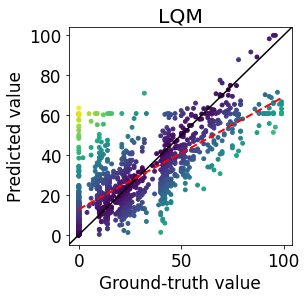

In [5]:
import matplotlib
from matplotlib import pyplot as plt

IMAGE_FOLDER = "/home/tim/data/SD301/images/latent/png/"

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

args = np.argsort(test_y)

sorted_gt = test_y[args]
sorted_p = predictions[args]
tn = np.array(test_names)[args]
diffs = sorted_p - sorted_gt


model = "LQM"
f = plt.figure(1, figsize=(4,4))
plt.axline((0, 0), (100, 100), color="black")
plt.xlabel("Ground-truth value")
plt.ylabel("Predicted value")
plt.scatter(sorted_gt, sorted_p, c=np.abs(diffs), s=15, cmap="viridis")
plt.title(model)
plt.xlim([-5, sorted_gt.max()+5])
plt.ylim([-5, sorted_gt.max()+5]) #sorted_p.max()+5])


m, b = np.polyfit(sorted_gt, sorted_p, 1)
plt.plot(sorted_gt, m*sorted_gt + b, color="red", linestyle='dashed', linewidth=2)


plt.show()

f.savefig(model + "_dashed.pdf", bbox_inches='tight')

Predicting Verifinger scores: 


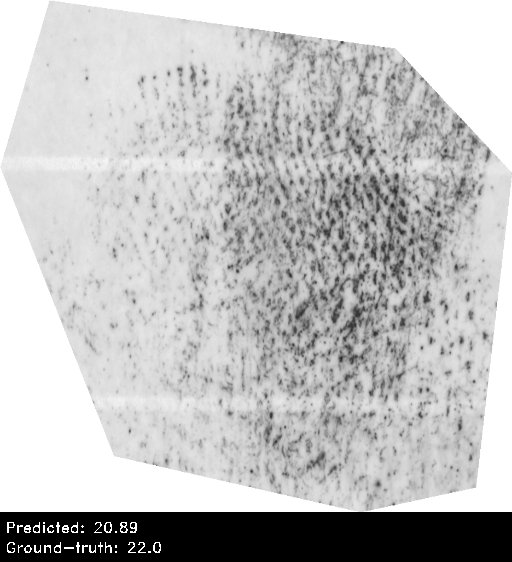

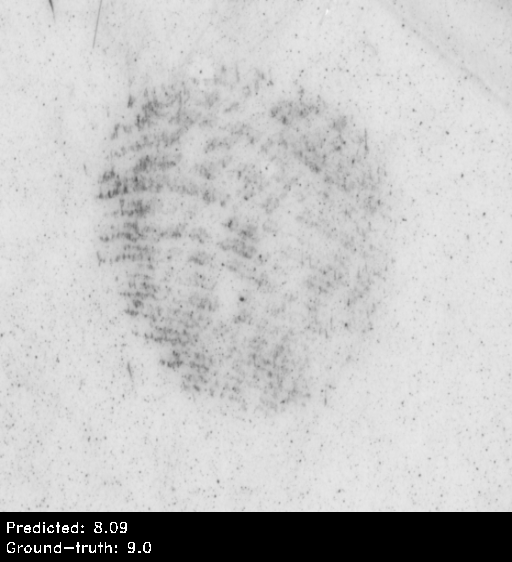

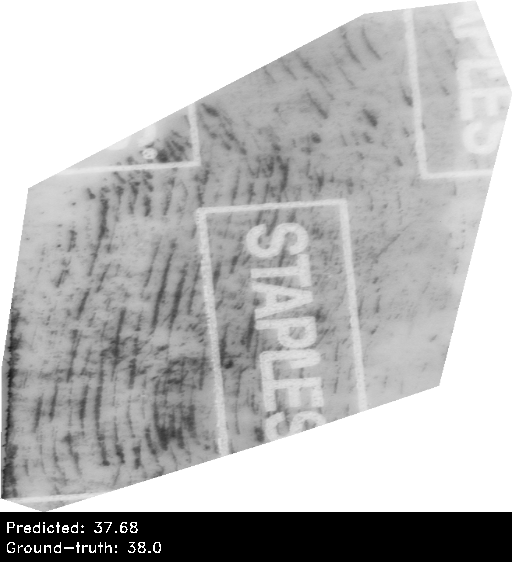

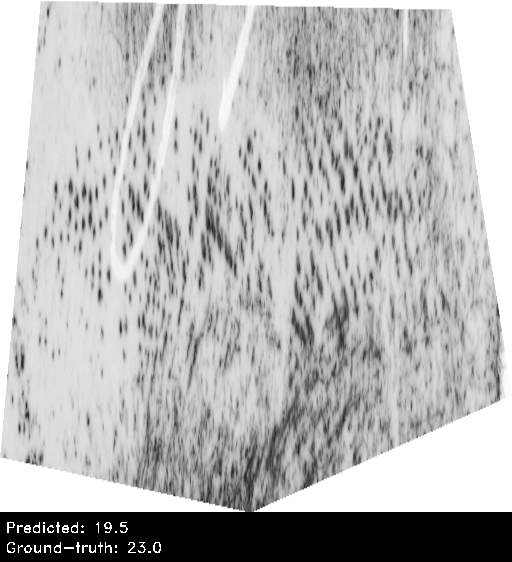

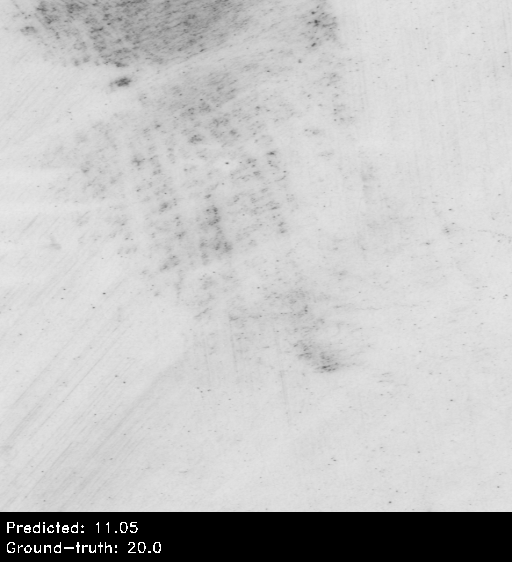

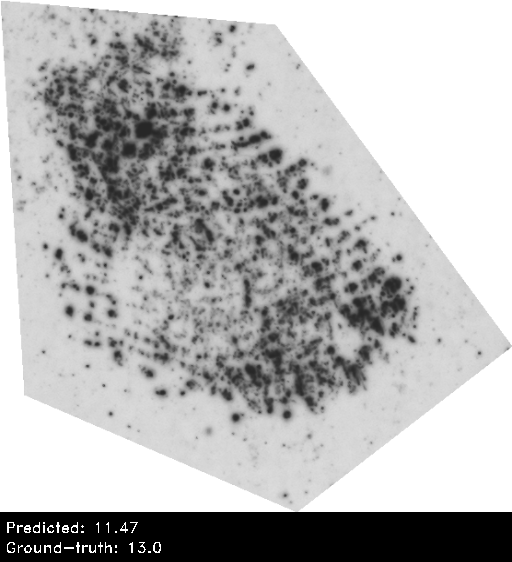

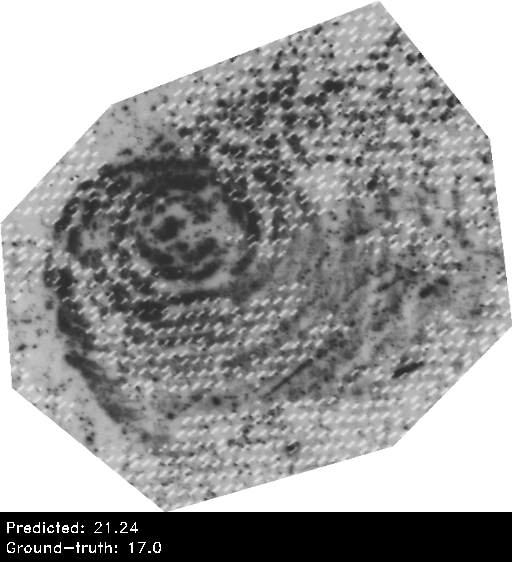

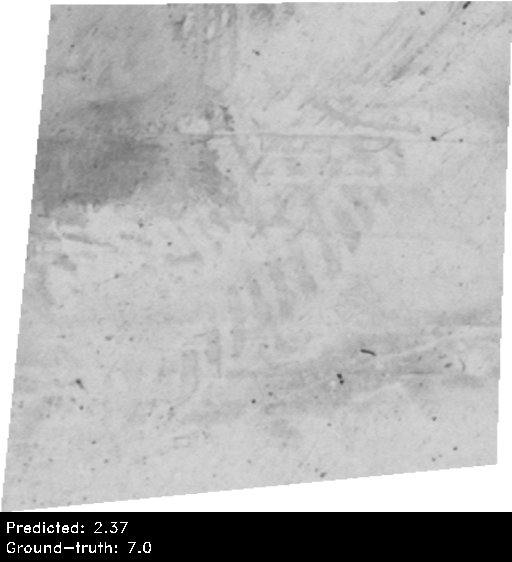

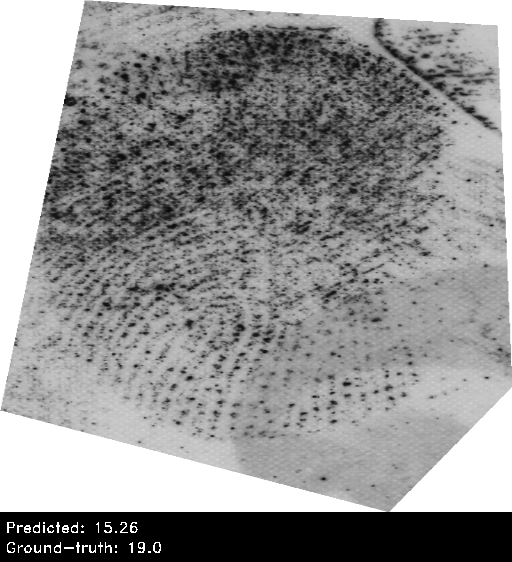

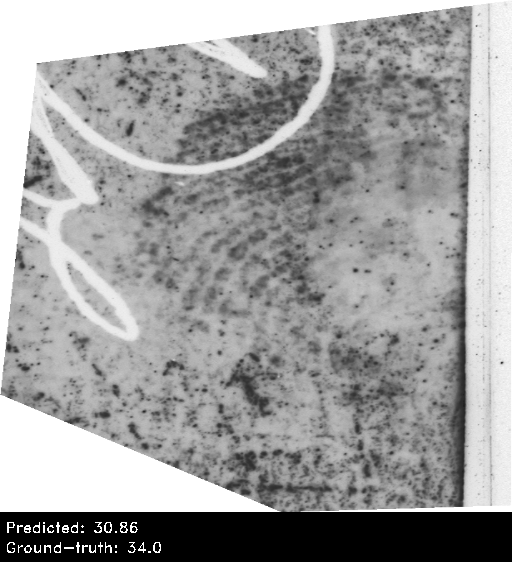

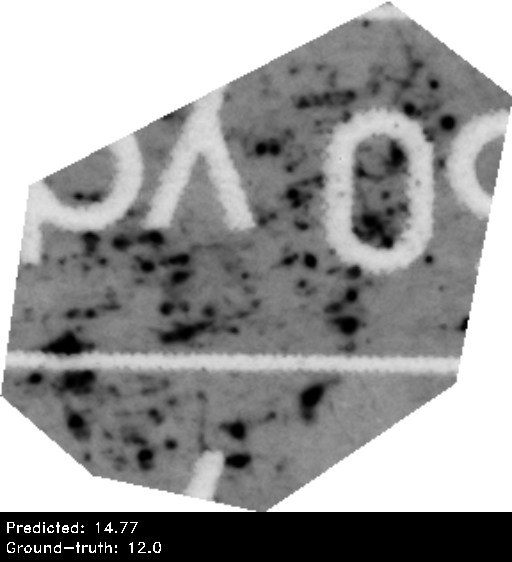

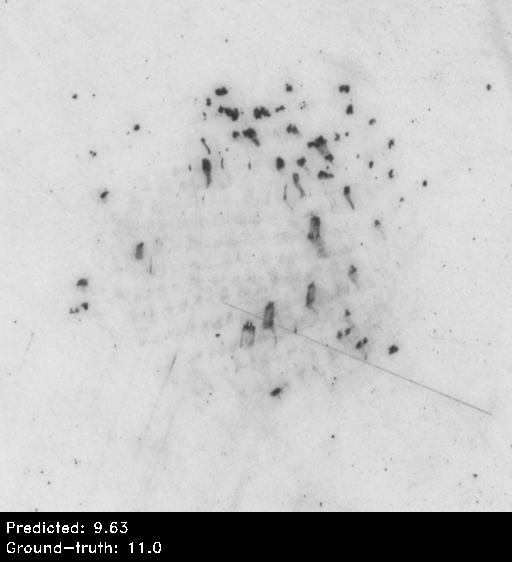

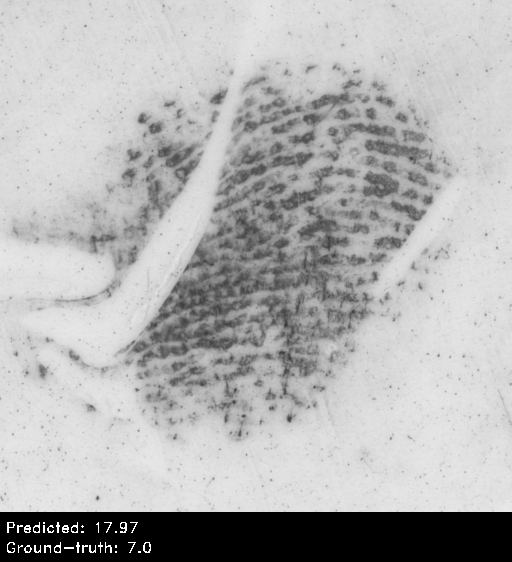

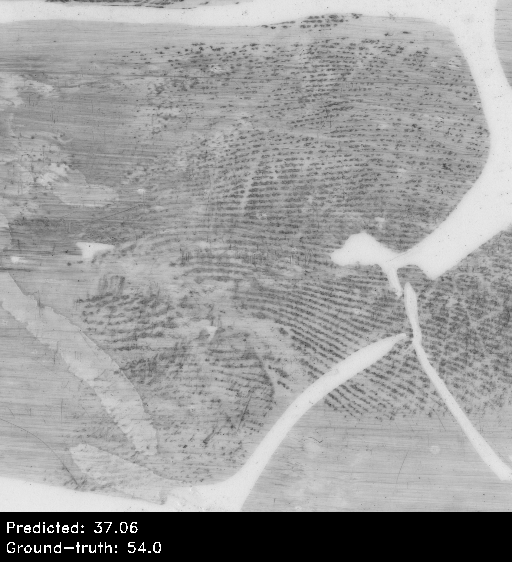

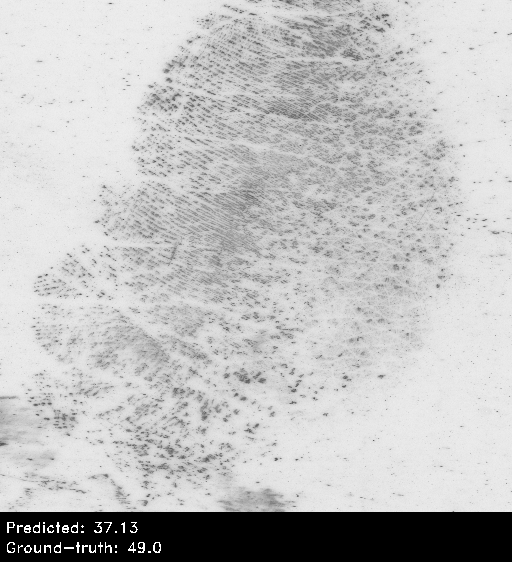

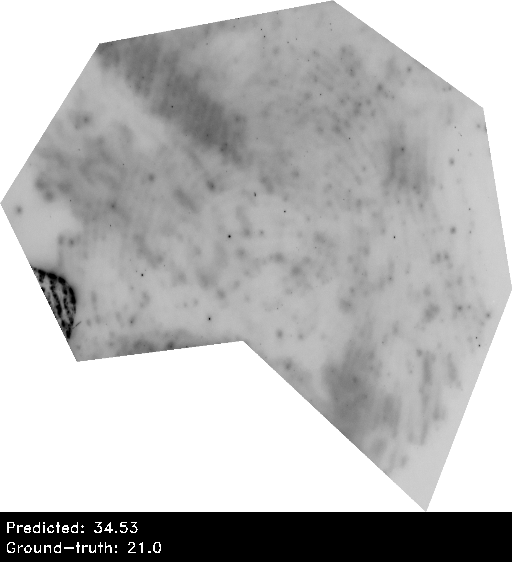

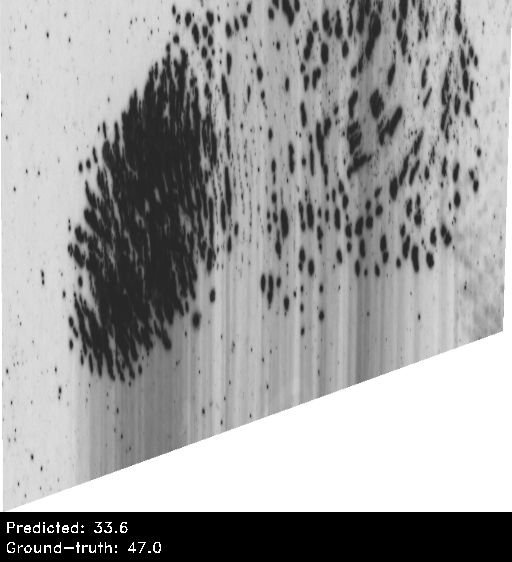

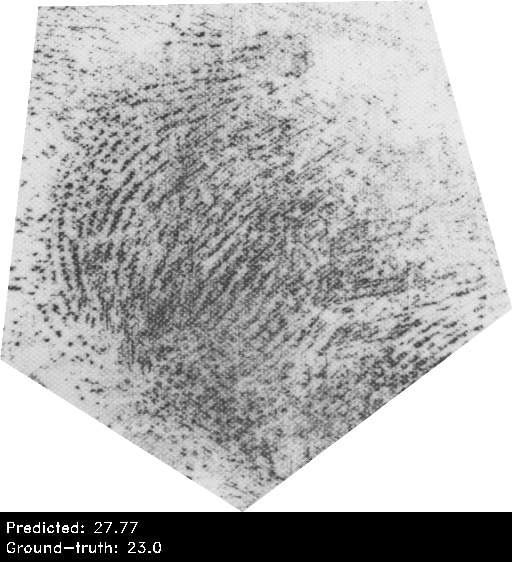

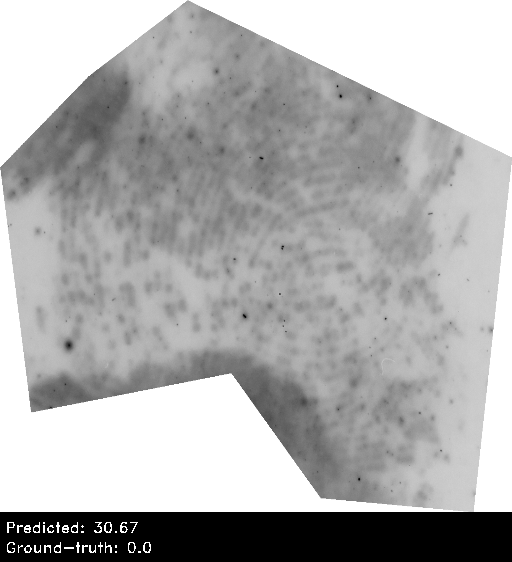

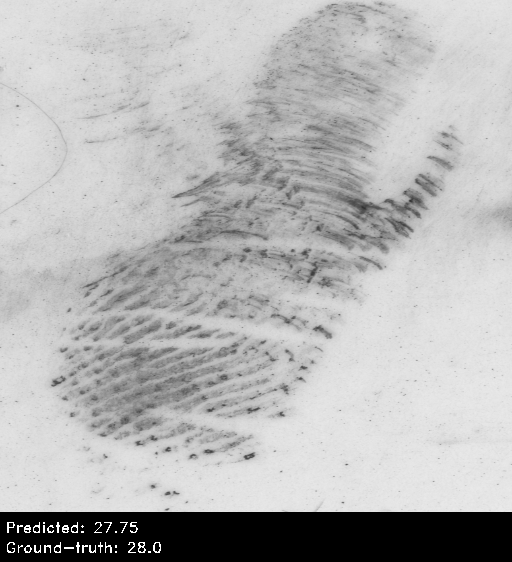

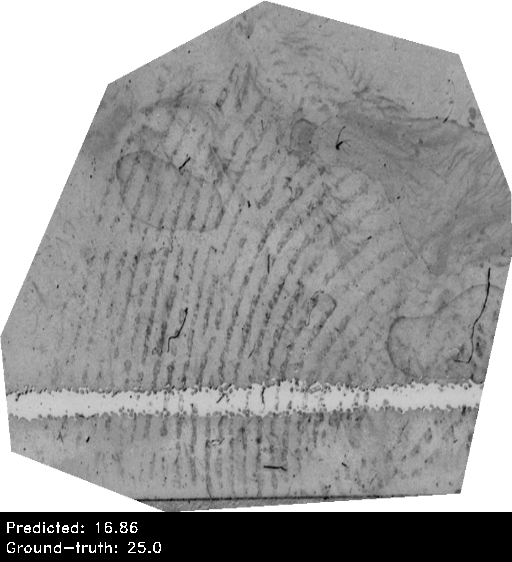

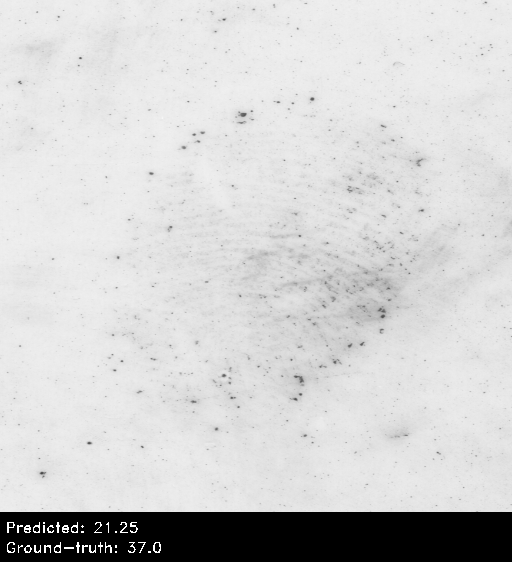

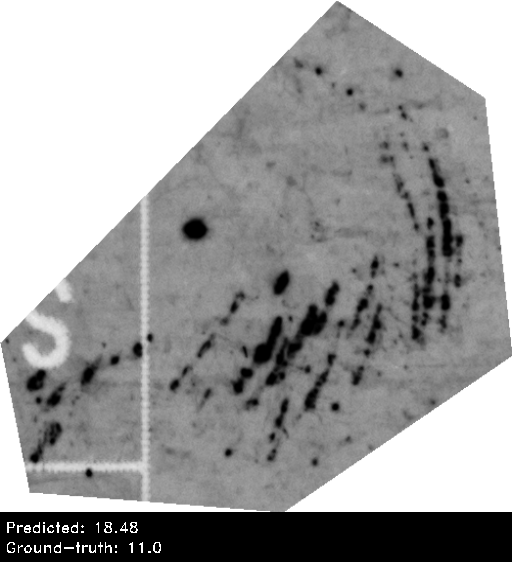

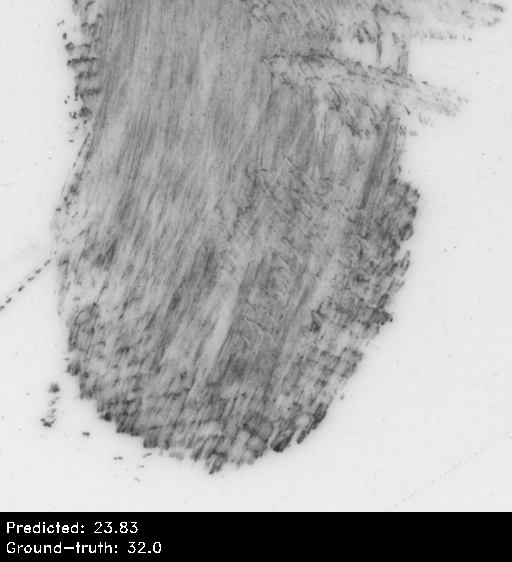

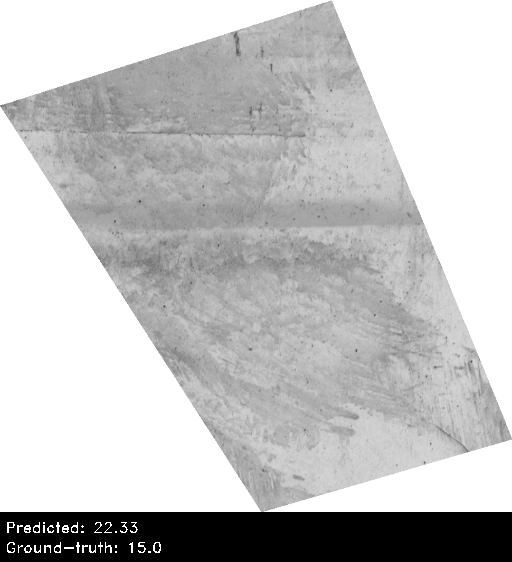

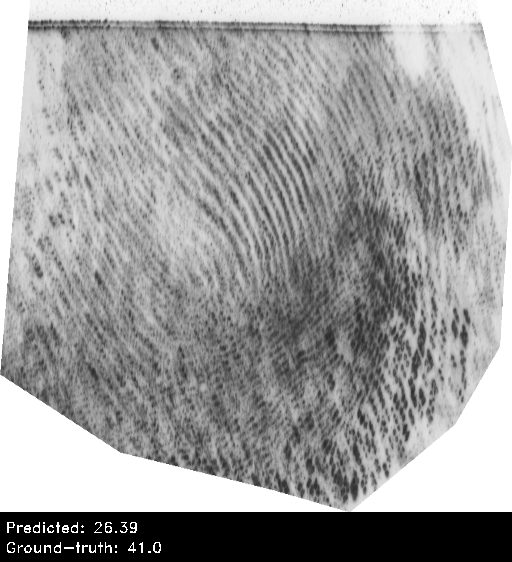

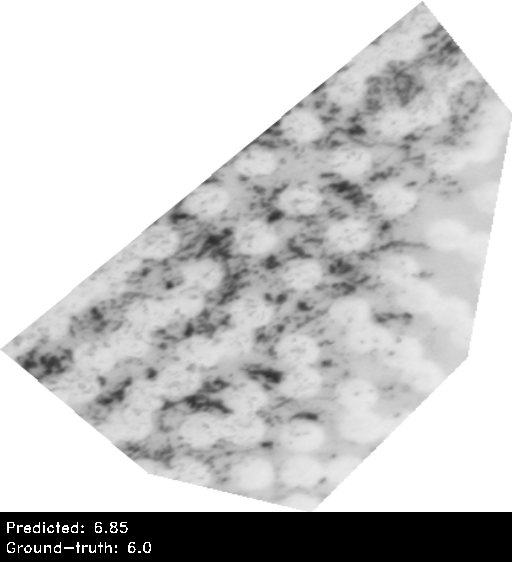

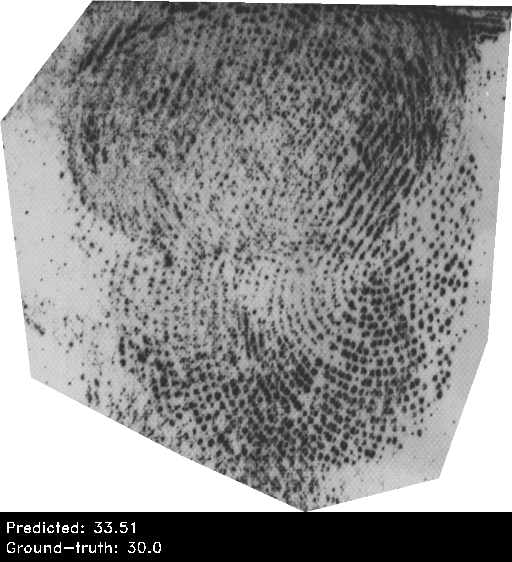

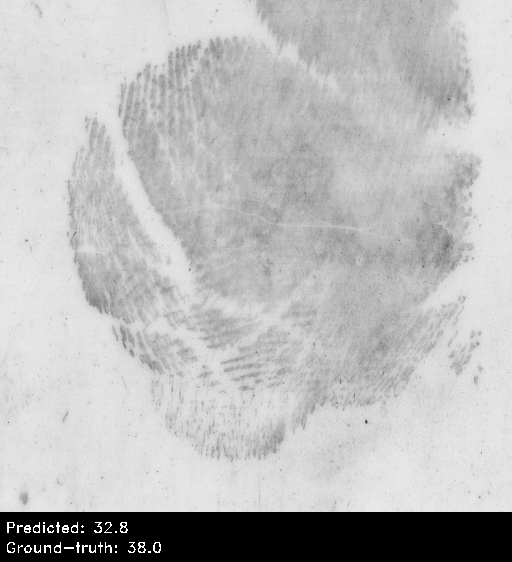

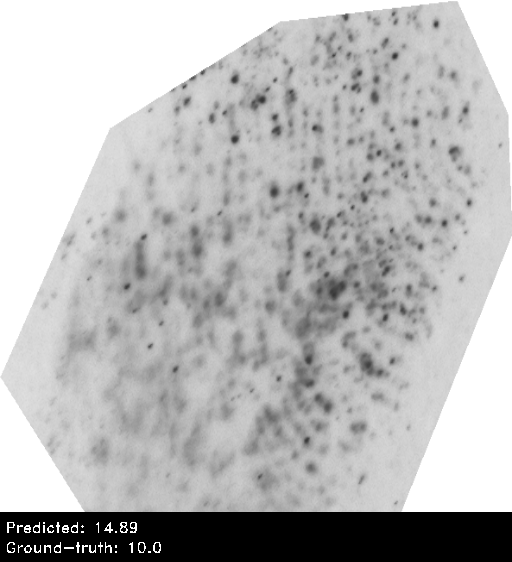

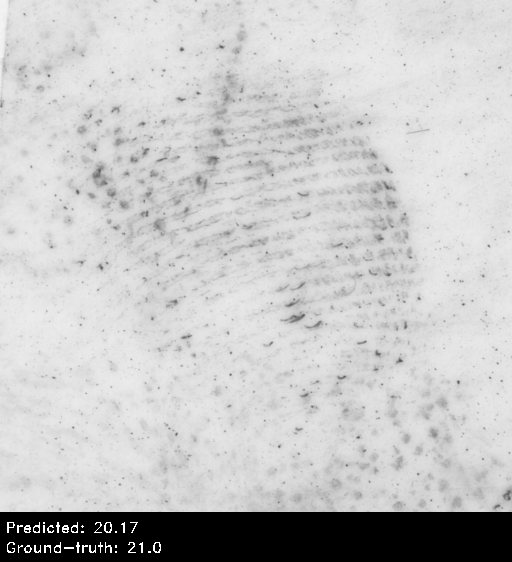

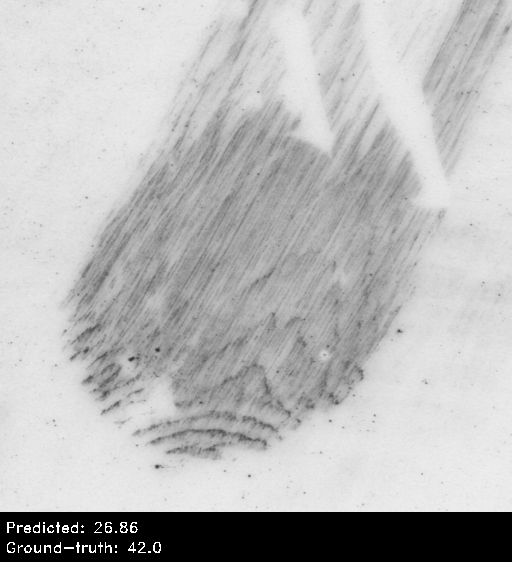

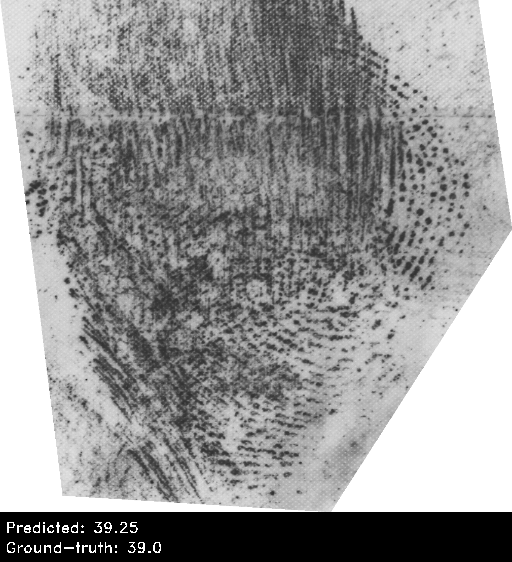

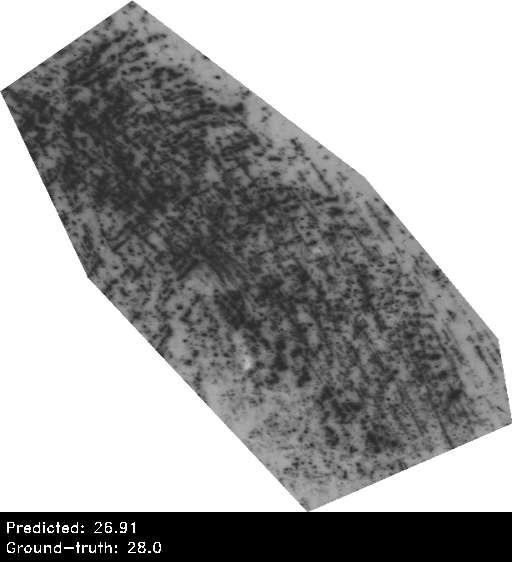

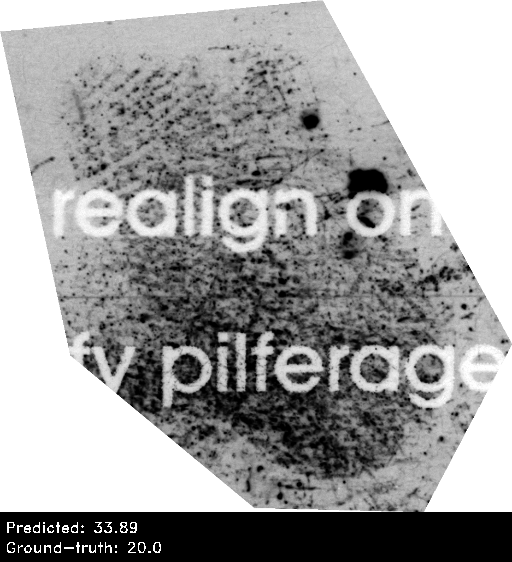

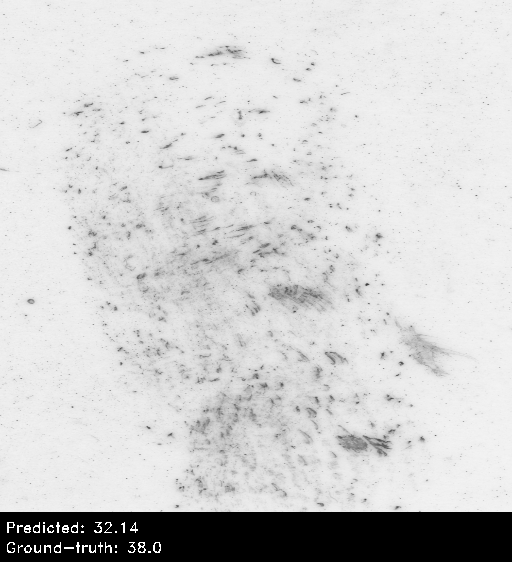

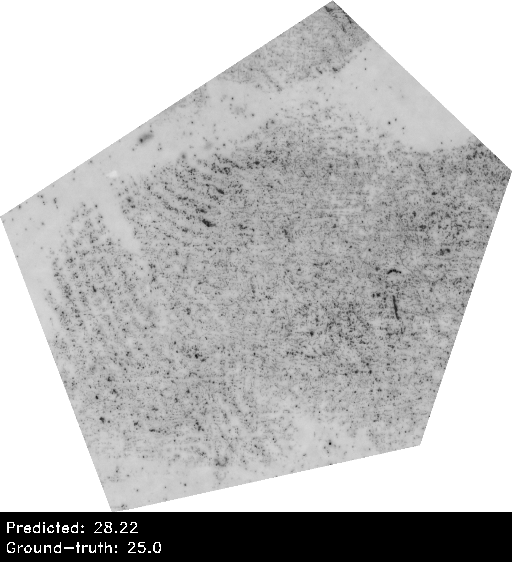

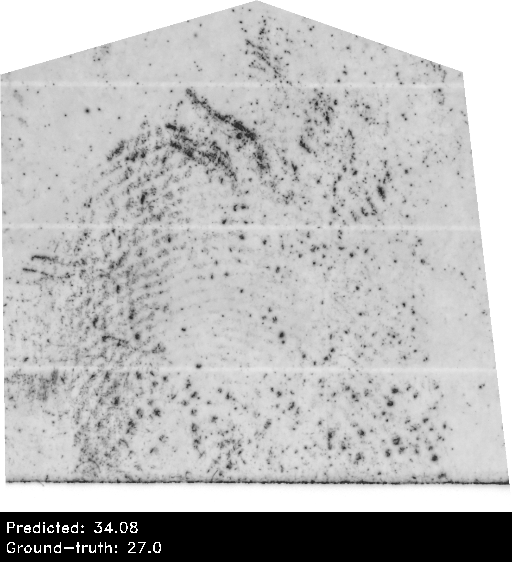

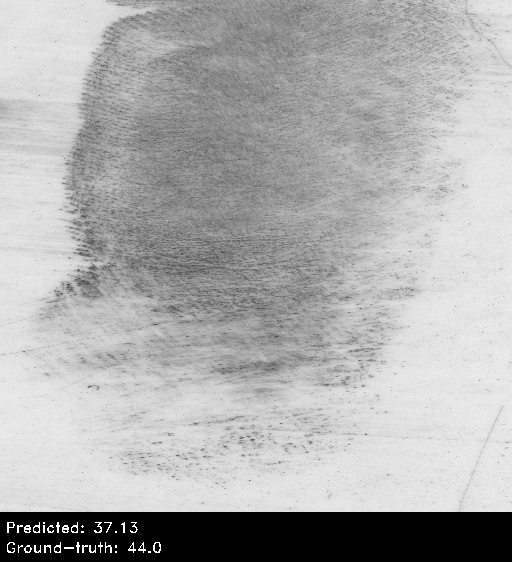

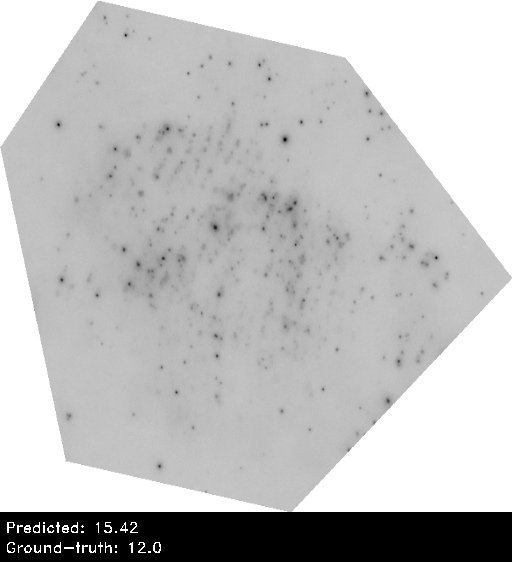

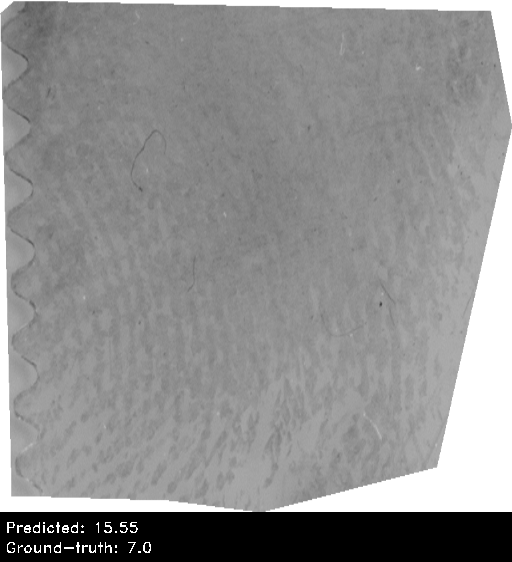

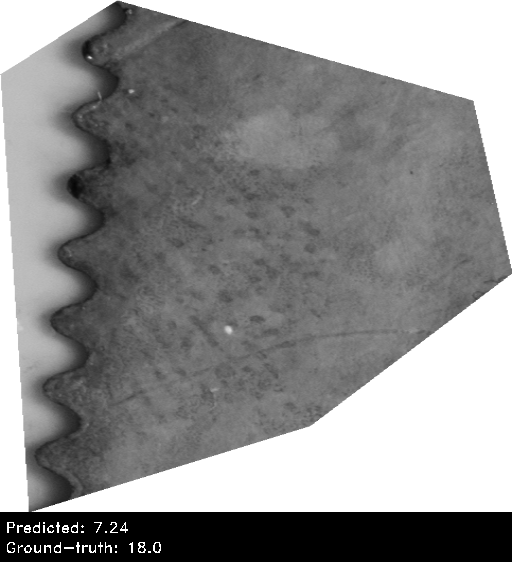

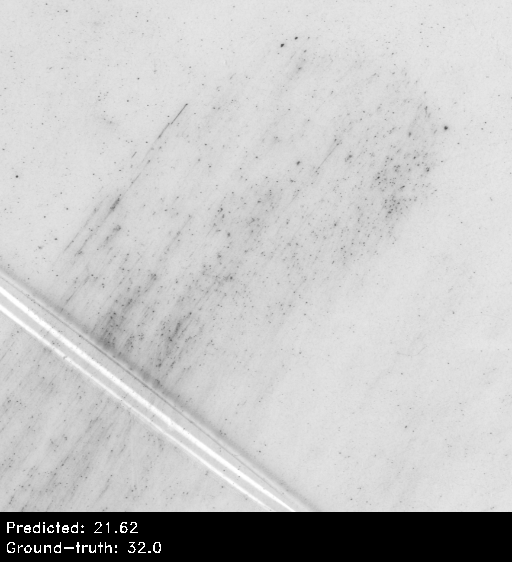

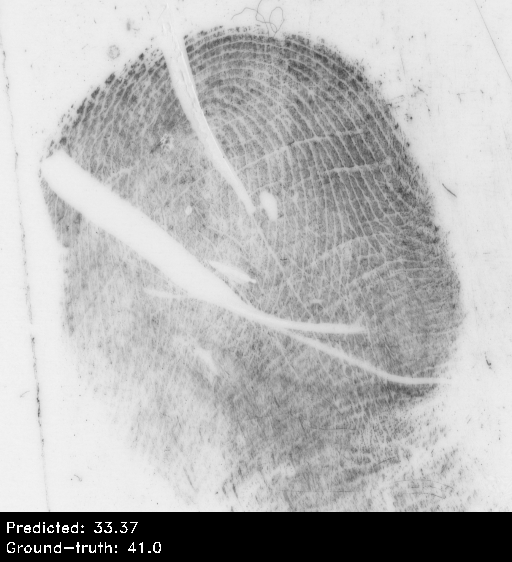

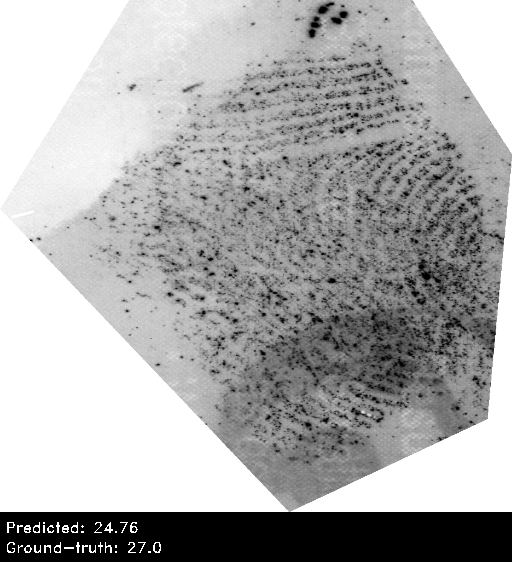

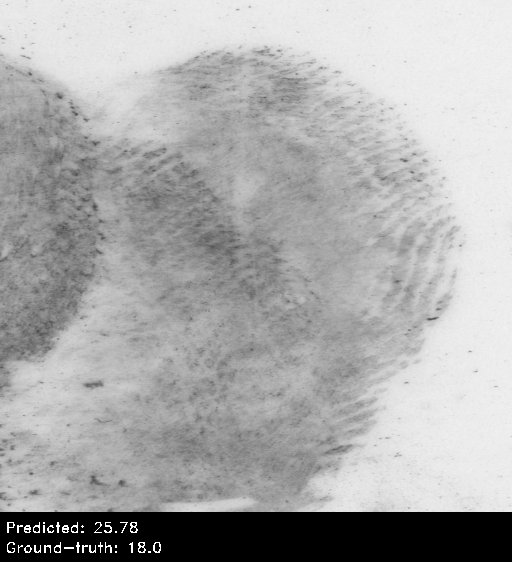

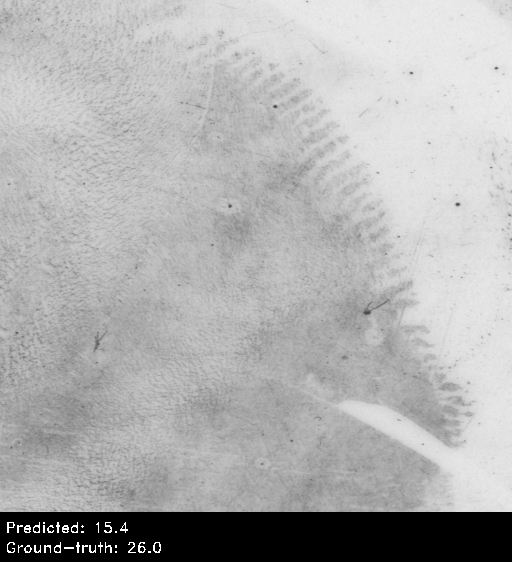

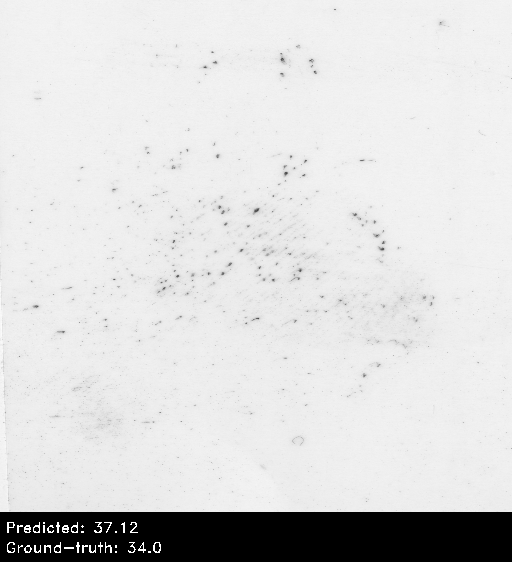

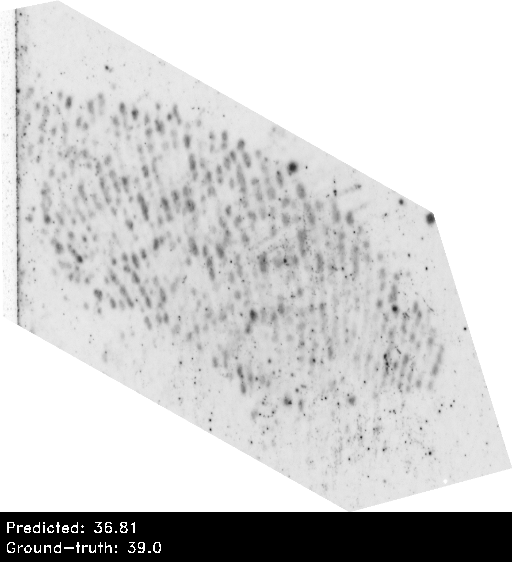

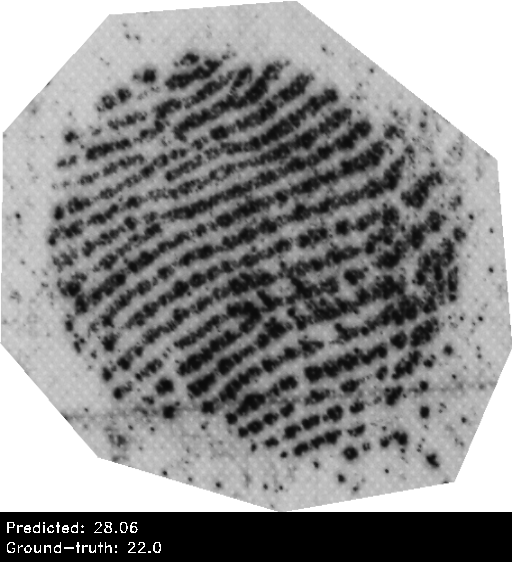

In [4]:
IMAGE_FOLDER = "/home/tim/data/SD301/images/latent/png/"

print("Predicting Verifinger scores: ")
for i in range(300, 350): 
    image = cv2.imread(IMAGE_FOLDER + test_names[i].split(".")[0] + ".png", 0)
    image = cv2.resize(image, (512, 512))
    
    image = cv2.copyMakeBorder(image, 0, 50, 0, 0, cv2.BORDER_CONSTANT, value=0)
    image = cv2.putText(image, "Predicted: " + str(round(predictions[i], 2)), (5, 532), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
    image = cv2.putText(image, "Ground-truth: " + str(test_y[i]), (5, 552), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
    
    
    
    cv2_imshow(image)
    
   